In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

## Results location

In [2]:
import os
from pathlib import Path

# Get the current working directory
home_path = Path(os.getcwd())
hyp_folder = home_path / "results/hyp_tuning"

In [3]:
frog_folder = hyp_folder / "frog_1"
rooster_folder = hyp_folder / "rooster_1"

## Read similarity dist. results

In [19]:
# Tested hyperparameters
num_of_freq_bins_list = [5, 10, 20, 30, 40, 50]
num_of_time_bins_list = [5, 10, 15, 20, 25]
p_values_list = [0.2, 0.3, 0.4, 0.5, 0.6]

In [16]:
# Saved results reference:
# [0]: spec_db
# [1]: importance
# [2]: uncertainty
# [3]: similarities <-- Analysing these results
# [4]: b_imp
# [5]: b_unc

In [27]:
def add_new_stats_to_df(similarities, df, freq_bins, time_bins, p_val):
    # Get stats of similarities
    mean = float(torch.mean(similarities))
    median = float(torch.median(similarities))
    std = float(torch.std(similarities))
    # Range
    min = float(torch.min(similarities))
    max = float(torch.max(similarities))
    range_100 = max - min
    # 80% range
    quant_10 = float(torch.quantile(similarities, 0.1))
    quant_90 = float(torch.quantile(similarities, 0.9))
    range_80 = quant_90 - quant_10

    # Create a new row
    new_row = {"freq_bins": freq_bins, "time_bins": time_bins, "p_val": p_val,
               "mean": mean, "median": median, "std": std,
               "min": min, "max": max, "range_100": range_100,
               "quant_10": quant_10, "quant_90": quant_90, "range_80": range_80}
    # Concat row to the dataframe
    df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

    return df

In [28]:
# Creating dataframes for frog and rooster results
columns = ["freq_bins", "time_bins", "p_val",
            "mean", "median", "std",
            "min", "max", "range_100",
            "quant_10", "quant_90", "range_80"
            ]
frog_df = pd.DataFrame(columns=columns)
rooster_df = pd.DataFrame(columns=columns)

# Loop over results and save them in the dataframes
for f_num in num_of_freq_bins_list:
    for t_num in num_of_time_bins_list:
        for p_val in p_values_list:
            # Load the results
            frog_path = frog_folder / f"frog_1_{t_num}_{f_num}_{p_val}_test.pt"
            rooster_path = rooster_folder / f"rooster_1_{t_num}_{f_num}_{p_val}_test.pt"

            loaded_frog = True
            loaded_rooster = True
            try:
                frog_results = torch.load(frog_path)
                frog_similarities = frog_results[3]
            except:
                print(f"Could not load {frog_path}")
                loaded_frog = False

            try:
                rooster_results = torch.load(rooster_path)
                rooster_similarities = rooster_results[3]
            except:
                print(f"Could not load {rooster_path}")
                loaded_rooster = False
            

            # Calculate the mean, median and std
            # Append the results to the dataframes
            
            if loaded_frog:
                frog_df = add_new_stats_to_df(frog_similarities, frog_df, f_num, t_num, p_val)

            if loaded_rooster:
                rooster_df = add_new_stats_to_df(rooster_similarities, rooster_df, f_num, t_num, p_val)

C:\Users\Zalán Zsiborás\AppData\Local\Temp\ipykernel_13624\1508466175.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)


In [29]:
# Save the dataframes
frog_df.to_csv(frog_folder / "frog_results.csv")
rooster_df.to_csv(rooster_folder / "rooster_results.csv")

# Analysing frog data

### Correlation mx.

               mean    median       std       min       max  range_100  \
freq_bins -0.450054 -0.462296 -0.582670 -0.208639 -0.485021  -0.488569   
time_bins -0.229862 -0.217161 -0.559796  0.027029 -0.434137  -0.569381   
p_val     -0.785735 -0.773266 -0.093494 -0.778191 -0.677127  -0.381276   

           quant_10  quant_90  range_80  
freq_bins -0.326108 -0.506251 -0.576435  
time_bins -0.119010 -0.325473 -0.542002  
p_val     -0.860610 -0.708510 -0.042400  


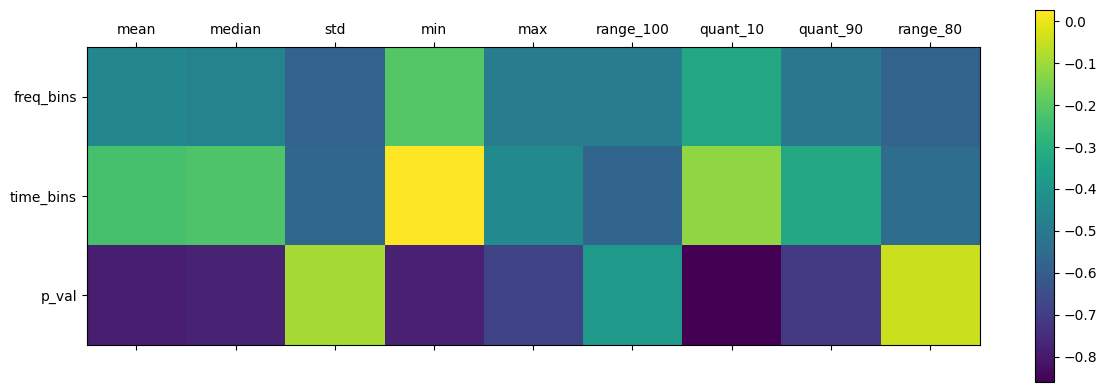

In [46]:
# Create correlation matrix for frog
corr_matrix = frog_df.corr()
print(corr_matrix.iloc[0:3, 3:])

# Plot the correlation matrix
plt.matshow(corr_matrix.iloc[0:3, 3:])
x_ticks = corr_matrix.columns[3:]
y_ticks = corr_matrix.index[0:3]
plt.xticks(range(len(x_ticks)), x_ticks)
plt.yticks(range(len(y_ticks)), y_ticks)
plt.colorbar()
# plt.savefig(frog_folder / "frog_corr_matrix.png")
plt.show()

               mean    median       std       min       max  range_100  \
freq_bins -0.191800 -0.157185 -0.540953  0.190800 -0.476650  -0.564287   
time_bins -0.012671 -0.008248 -0.529880  0.588201 -0.302171  -0.652963   
p_val     -0.962343 -0.954525 -0.543300 -0.651444 -0.723268  -0.261685   

           quant_10  quant_90  range_80  
freq_bins  0.026275 -0.350203 -0.523076  
time_bins  0.290640 -0.189059 -0.501158  
p_val     -0.898406 -0.899319 -0.578906  


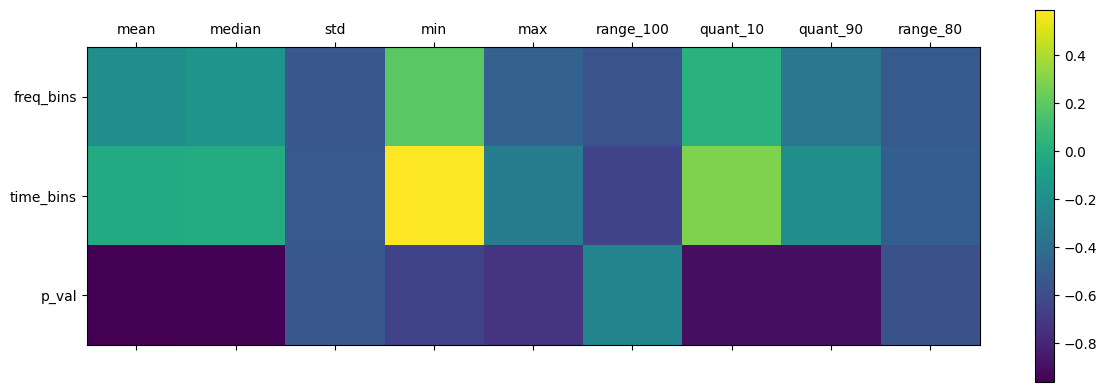

In [48]:
# Compute correlation matrix for rooster
corr_matrix = rooster_df.corr()
print(corr_matrix.iloc[0:3, 3:])
# Plot the correlation matrix
plt.matshow(corr_matrix.iloc[0:3, 3:])
x_ticks = corr_matrix.columns[3:]
y_ticks = corr_matrix.index[0:3]
plt.xticks(range(len(x_ticks)), x_ticks)
plt.yticks(range(len(y_ticks)), y_ticks)
plt.colorbar()
# plt.savefig(rooster_folder / "rooster_corr_matrix.png")
plt.show()
